In [ ]:
import os
import numpy as np
import pandas as pd
import optuna
import warnings
warnings.filterwarnings("ignore")

# ML libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import xgboost as xgb
from xgboost.callback import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

RND = 42
np.random.seed(RND)

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")


In [ ]:
# Work on copies
df = train.copy()
test_df = test.copy()

# Drop known leak columns
for c in ["Unnamed: 0", "MajorGroup"]:
    if c in df.columns:
        df = df.drop(columns=[c])
    if c in test_df.columns:
        test_df = test_df.drop(columns=[c])

# Keeping company meta if needed separately
meta_cols = ["company_name", "fyear"]
for c in meta_cols:
    if c not in df.columns:
        # if missing in train, ignore
        pass

# Merge rare Division categories into "Other"
if "Division" in df.columns:
    div_counts = df["Division"].value_counts()
    rare_divs = div_counts[div_counts < 100].index.tolist()
    df["Division"] = df["Division"].replace(rare_divs, "Other")
    # apply same mapping to test
    if "Division" in test_df.columns:
        test_df["Division"] = test_df["Division"].replace(rare_divs, "Other")

# Split features / target
y = df["status_label"].copy()
X = df.drop(columns=["status_label", "company_name", "fyear"], errors="ignore")
X_test = test_df.drop(columns=["company_name", "fyear"], errors="ignore")

# Categorical cols (for CatBoost and for encoder)
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Categorical columns detected:", cat_cols)

# Force string dtype for categorical columns
for c in cat_cols:
    X[c] = X[c].astype(str)
    X_test[c] = X_test[c].astype(str)

# Prepare OrdinalEncoder for XGBoost / LightGBM (they need numeric)
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
if cat_cols:
    oe.fit(pd.concat([X[cat_cols], X_test[cat_cols]], axis=0))
    X_cat_enc = oe.transform(X[cat_cols])
    X_test_cat_enc = oe.transform(X_test[cat_cols])

    # replace cat columns with encoded numeric for tree libs
    X_enc = X.copy()
    X_test_enc = X_test.copy()
    for i, c in enumerate(cat_cols):
        X_enc[c] = X_cat_enc[:, i].astype(int)
        X_test_enc[c] = X_test_cat_enc[:, i].astype(int)
else:
    X_enc = X.copy()
    X_test_enc = X_test.copy()

# Encode target to 0/1
y_enc = y.replace({"alive": 0, "failed": 1}).astype(int)

# Final shapes check
print("Train shape:", X_enc.shape, "Test shape:", X_test_enc.shape)


Categorical columns detected: ['Division']
Train shape: (62789, 19) Test shape: (15893, 19)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X_enc, y_enc, test_size=0.2, random_state=RND, stratify=y_enc
)

# Keep CatBoost pools (CatBoost will get cat_features list by name)
cat_features_for_cb = cat_cols  # list of column names (strings)
print("Train / Val shapes:", X_train.shape, X_val.shape)


Train / Val shapes: (50231, 19) (12558, 19)


In [ ]:
# ---- CatBoost (using the cleaned best-ish params from earlier optuna) ----
cb_params = {
    "depth": 8,
    "learning_rate": 0.013945439342515105,
    "iterations": 790,
    "l2_leaf_reg": 4.394405755171258,
    "bagging_temperature": 0.3675618245330172,
    "subsample": 0.7033831815584286,
    "random_strength": 2.4299151806850863,
    "border_count": 73,
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "eval_metric": "F1",
    "random_state": RND,
    "verbose": 100
}

cb_model = CatBoostClassifier(**cb_params)
cb_model.fit(
    X_train, y_train,
    cat_features=cat_features_for_cb,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=50
)
cb_val_proba = cb_model.predict_proba(X_val)[:, 1]
cb_test_proba = cb_model.predict_proba(X_test_enc)[:, 1]

# ---- LightGBM ----
lgb_params = {
    "objective": "binary",
    "n_estimators": 1000,
    "learning_rate": 0.02,
    "num_leaves": 64,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.0,
    "reg_lambda": 2.0,
    "random_state": RND,
    "n_jobs": -1,
    "importance_type": "gain"
}
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=0)  # silence logs
    ]
)
lgb_val_proba = lgb_model.predict_proba(X_val)[:, 1]
lgb_test_proba = lgb_model.predict_proba(X_test_enc)[:, 1]

# ---- XGBoost ----
xgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.02,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.0,
    "reg_lambda": 2.0,
    "random_state": RND,
    "n_jobs": -1,
    "objective": "binary:logistic",
    "eval_metric": "logloss"
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test_enc)

watchlist = [(dtrain, "train"), (dval, "val")]

bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False
)

# Predict using the best iteration
xgb_val_proba = bst.predict(dval, iteration_range=(0, bst.best_iteration+1))
xgb_test_proba = bst.predict(dtest, iteration_range=(0, bst.best_iteration+1))


# Quick check: individual val macro-F1 at 0.5
from sklearn.metrics import f1_score
print("CatBoost val macro-F1 (0.5):", f1_score(y_val, (cb_val_proba>0.5).astype(int), average="macro"))
print("LightGBM val macro-F1 (0.5):", f1_score(y_val, (lgb_val_proba>0.5).astype(int), average="macro"))
print("XGBoost val macro-F1 (0.5):", f1_score(y_val, (xgb_val_proba>0.5).astype(int), average="macro"))


0:	learn: 0.6414214	test: 0.6551824	best: 0.6551824 (0)	total: 61.9ms	remaining: 48.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6871773751
bestIteration = 23

Shrink model to first 24 iterations.
[LightGBM] [Info] Number of positive: 3362, number of negative: 46869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4600
[LightGBM] [Info] Number of data points in the train set: 50231, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066931 -> initscore=-2.634820
[LightGBM] [Info] Start training from score -2.634820
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's binary_logloss: 0.197776
CatBoost val macro-F1 (0.5): 0.47451678700786365
LightGBM val macro-F1 (0.5): 0.5407471220736109
XGBoost val macro-F1 (0.5): 0.5436521

In [13]:
# We'll optimize weights w1,w2,w3 in [0,1] (they'll be normalized), and a threshold t in [0.01,0.9]
val_stack = np.vstack([cb_val_proba, lgb_val_proba, xgb_val_proba]).T
test_stack = np.vstack([cb_test_proba, lgb_test_proba, xgb_test_proba]).T

def ensemble_score(weights, threshold):
    # weights: length-3 array (not necessarily normalized)
    w = np.array(weights)
    w = np.abs(w)
    if w.sum() == 0:
        w = np.ones_like(w)
    w = w / w.sum()
    proba = (val_stack * w).sum(axis=1)
    preds = (proba > threshold).astype(int)
    return f1_score(y_val, preds, average="macro")

def objective_ens(trial):
    w1 = trial.suggest_float("w1", 0.0, 1.0)
    w2 = trial.suggest_float("w2", 0.0, 1.0)
    w3 = trial.suggest_float("w3", 0.0, 1.0)
    t = trial.suggest_float("thr", 0.01, 0.9)
    return ensemble_score([w1,w2,w3], t)

study_ens = optuna.create_study(direction="maximize")
study_ens.optimize(objective_ens, n_trials=80, show_progress_bar=True)

best = study_ens.best_params
w = np.array([best["w1"], best["w2"], best["w3"]])
w = np.abs(w); w = w / w.sum()
best_thr = best["thr"]
print("Best normalized weights:", w)
print("Best threshold:", best_thr)
print("Best validation macro-F1:", study_ens.best_value)


[I 2025-11-04 13:47:23,215] A new study created in memory with name: no-name-e9b1460f-26ec-4643-b66f-693878c3c0ba


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-11-04 13:47:23,265] Trial 0 finished with value: 0.4826776519052523 and parameters: {'w1': 0.12668255182060761, 'w2': 0.05062407729838969, 'w3': 0.2544154781463226, 'thr': 0.8408109313908045}. Best is trial 0 with value: 0.4826776519052523.
[I 2025-11-04 13:47:23,276] Trial 1 finished with value: 0.6161051671194725 and parameters: {'w1': 0.4757353780470711, 'w2': 0.7202786559072748, 'w3': 0.5899577606972358, 'thr': 0.20497991425555578}. Best is trial 1 with value: 0.6161051671194725.
[I 2025-11-04 13:47:23,295] Trial 2 finished with value: 0.5095478443183874 and parameters: {'w1': 0.5797016371346041, 'w2': 0.6674952139254041, 'w3': 0.3223466911019416, 'thr': 0.6107800018437757}. Best is trial 1 with value: 0.6161051671194725.
[I 2025-11-04 13:47:23,312] Trial 3 finished with value: 0.4826776519052523 and parameters: {'w1': 0.2752175086768731, 'w2': 0.1848110835225566, 'w3': 0.08797325986519888, 'thr': 0.849369317471842}. Best is trial 1 with value: 0.6161051671194725.
[I 2025-1

In [15]:
# Apply best weights to test and val
w = np.array([study_ens.best_params["w1"], study_ens.best_params["w2"], study_ens.best_params["w3"]])
w = np.abs(w); w = w / w.sum()
best_thr = study_ens.best_params["thr"]

val_ens_proba = (val_stack * w).sum(axis=1)
val_ens_preds = (val_ens_proba > best_thr).astype(int)

test_ens_proba = (test_stack * w).sum(axis=1)
test_ens_preds = (test_ens_proba > best_thr).astype(int)

# Validation report
print("Validation classification report (ensemble):")
print(classification_report(y_val, val_ens_preds, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_val, val_ens_preds))
print("Validation macro-F1:", f1_score(y_val, val_ens_preds, average="macro"))

# Convert preds back to strings for submission
test_status_label = np.where(test_ens_preds==1, "failed", "alive")


Validation classification report (ensemble):
              precision    recall  f1-score   support

           0     0.9572    0.9383    0.9476     11717
           1     0.3256    0.4150    0.3649       841

    accuracy                         0.9032     12558
   macro avg     0.6414    0.6766    0.6563     12558
weighted avg     0.9149    0.9032    0.9086     12558

Confusion matrix:
 [[10994   723]
 [  492   349]]
Validation macro-F1: 0.6562540052243276


In [16]:
submission = pd.DataFrame({
    "company_name": test["company_name"],
    "status_label": test_status_label
})
submission.to_csv("submission_ensemble_weighted.csv", index=False)
print("Saved submission_ensemble_weighted.csv")


Saved submission_ensemble_weighted.csv


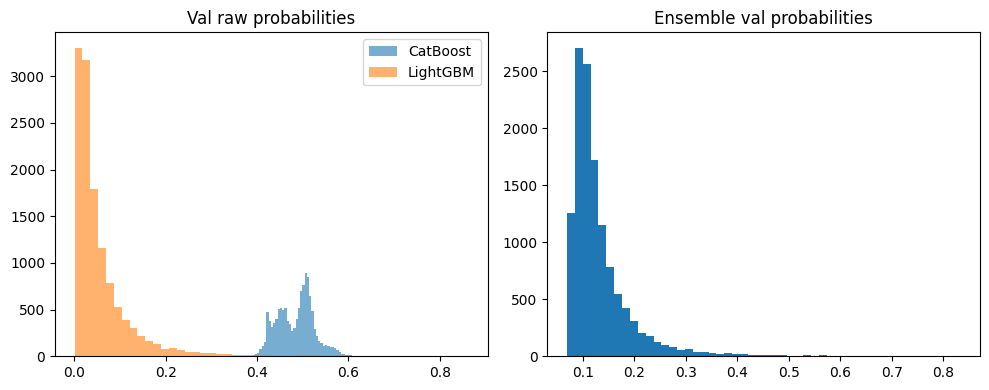

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(val_stack[:,0], bins=50, alpha=0.6, label="CatBoost")
plt.hist(val_stack[:,1], bins=50, alpha=0.6, label="LightGBM")
plt.legend(); plt.title("Val raw probabilities")

plt.subplot(1,2,2)
plt.hist(val_ens_proba, bins=50)
plt.title("Ensemble val probabilities")
plt.tight_layout()
plt.show()
